# NiN
NIN结构的mlp conv结构是将多层感知机（MLP）和卷积(CONV)结合在一起，即在传统的卷积层之间加上了MLP层，一个卷积核对原图的同一片相同大小区域卷积得到一个数，96个卷积核同样的操作得到96个数，即96个通道上同一个位置的一个元素，然后将这96个元素做一下全连接，又得到96个元素。相当于在对每一个patch的不同卷积核结果做了一个MLP。

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 超参

In [2]:
EPOCHS = 50
BATCH_SIZE = 256
LR = 1e-5
VERBOSE = 1
IMAGE_SIZE = 224

## 导入数据集

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = tf.reshape(train_images, (train_images.shape[0], train_images.shape[1], train_images.shape[2], -1))
test_images = tf.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2], -1))

In [5]:
train_images = tf.image.resize_with_pad(train_images, IMAGE_SIZE, IMAGE_SIZE)
test_images = tf.image.resize_with_pad(test_images, IMAGE_SIZE, IMAGE_SIZE)

train_images = tf.cast(train_images, dtype=tf.float32) / 255.
test_images = tf.cast(test_images, dtype=tf.float32) / 255.

In [6]:
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

## 网络中的网络

In [7]:
def nin_block(num_channels, kernel_size, strides, padding):
    blk = keras.models.Sequential()
    blk.add(keras.layers.Conv2D(num_channels, kernel_size, strides=strides, padding=padding, activation='relu')) 
    blk.add(keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu')) 
    blk.add(keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu'))    
    return blk

In [8]:
model = keras.models.Sequential()

model.add(keras.Input((224, 224, 1)))

model.add(nin_block(96, kernel_size=11, strides=4, padding='valid'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2))

model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2))

model.add(nin_block(384, kernel_size=3, strides=1, padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2))
model.add(keras.layers.Dropout(0.5))

model.add(nin_block(10, kernel_size=3, strides=1, padding='same'))

model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 54, 54, 96)        30336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 26, 26, 256)       746240    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 12, 12, 384)       1180800   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 384)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 384)         0

## 设置优化器和损失函数

In [9]:
optimizer = keras.optimizers.Adam(lr=LR)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 开始训练

In [10]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)

Train on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 20s 2ms/sample - loss: 4.0520 - accuracy: 0.0922
Epoch 2/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 3.0562 - accuracy: 0.1186
Epoch 3/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.9194 - accuracy: 0.1685
Epoch 4/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.8015 - accuracy: 0.2212
Epoch 5/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.6028 - accuracy: 0.2535
Epoch 6/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.3494 - accuracy: 0.3035
Epoch 7/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.1598 - accuracy: 0.3305
Epoch 8/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 2.0513 - accuracy: 0.3393
Epoch 9/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 1.9131 - accuracy: 0.3657
Epoch 10/50
10

## 绘制梯度下降图

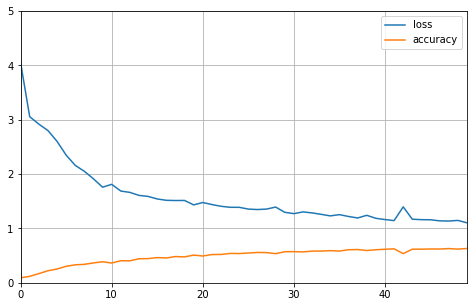

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 5)
    plt.show()
    
plot_learning_curves(history)

## 测试训练好的模型

In [16]:
model.evaluate(test_images, test_labels)

3000/3000 [==============================] - 2s 636us/sample - loss: 1.0264 - accuracy: 0.6457


[1.0264339504241944, 0.64566666]

## 保存模型 

In [13]:
model.save('./save/save_model/model.h5')

In [14]:
model.save_weights('./save/save_weights/model_weights.h5')